In [1]:
# PACS details
domains = ['photo', 'art_painting', 'cartoon', 'sketch']
classes = ['dog', 'elephant', 'giraffe', 'guitar', 'horse','house', 'person']

# Set parameters

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim.swa_utils import AveragedModel, SWALR

import torchvision.datasets as Datasets
from torchvision import models
from torchvision.datasets import ImageFolder, DatasetFolder

from utils import *
import os

import numpy as np
import matplotlib.pyplot as plt

from model.resnet18_selfreg import resnet18


ModuleNotFoundError: No module named 'model.utils'

In [3]:
##############################
# Training Setting
##############################

#학습에 사용할 모델 
# resnet18(pytorch official):'resnet18_classic'
# SelfReg : 'resnet18' 
used_model = 'resnet18'

save_name = 'SelfReg_official_test'     # save_dir name
                                                     # save_path : resnet_18/pacs/{save_name}/
dataset ='pacs'        
pacs_ver = 'pacs_official_split' 
number_of_tests = 20   
gpu_num = 0
n_workers = 6

##############################
# Basic Hyper-parameters
##############################

# Training Setting
    # classic : classic training
    # IDCL : classic + Inter-domain curriculum learning
    
training_setting = 'classic'
is_self_reg = True  # Using SefReg Flag

epochs = 30
batch_size = 128
is_pretrained = True  # Use ImageNet pretrain weight ?
used_optimizer = 'SGD' # 'Adam' or 'SGD'

#Learning rate
lr = 4e-3 
lr_decay_epoch = [100]
lr_decay_gamma = 0.1


train_tf, test_tf = get_tf(augment=True)


In [4]:
device= torch.device('cpu')
use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    device = torch.device("cuda:{}".format(gpu_num))
print(device)



#모델 세팅 저장 
model_settings={
    "used_model" : used_model,
    "dataset" : dataset,
    "save_name" : save_name,
    "pacs_ver" : pacs_ver,
    "number_of_tests" : number_of_tests,
    "training_setting" : training_setting,
    "epochs" : epochs,
    "batch_size" : batch_size,
    "is_pretrained" : is_pretrained,
    "lr" : lr,
    "lr_decay_epoch" : lr_decay_epoch,
    "lr_decay_gamma" : lr_decay_gamma,
    "gpu_num" : gpu_num
}

criterion = nn.CrossEntropyLoss().to(device)

Using CUDA
cuda:1


# Functions

In [5]:
def classic_setting(test_domain_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model,pacs_ver,used_optimizer):
    
    train_set1 = ImageFolder(root=os.path.join('{}/train'.format(pacs_ver),
                                               domains[(test_domain_idx+1)%len(domains)]), transform = train_tf)
    train_set2 = ImageFolder(root=os.path.join('{}/train'.format(pacs_ver),
                                               domains[(test_domain_idx+2)%len(domains)]), transform = train_tf)
    train_set3 = ImageFolder(root=os.path.join('{}/train'.format(pacs_ver),
                                               domains[(test_domain_idx+3)%len(domains)]), transform = train_tf)
        
    val_set1 = ImageFolder(root=os.path.join('{}/val'.format(pacs_ver),
                                               domains[(test_domain_idx+1)%len(domains)]), transform = test_tf)
    val_set2 = ImageFolder(root=os.path.join('{}/val'.format(pacs_ver),
                                               domains[(test_domain_idx+2)%len(domains)]), transform = test_tf)
    val_set3 = ImageFolder(root=os.path.join('{}/val'.format(pacs_ver),
                                               domains[(test_domain_idx+3)%len(domains)]), transform = test_tf)
    
    train_set = train_set1+train_set2+train_set3
    val_set = val_set1+val_set2+val_set3
    test_set = ImageFolder(root=os.path.join('{}/test'.format(pacs_ver),domains[test_domain_idx]), transform = test_tf)
    
    
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=n_workers)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=n_workers)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=n_workers)
    
    
    if used_model=='vgg16':
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features=len(classes)
    elif used_model=='inceptionv3':
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = len(classes)
        model.fc.out_features=len(classes)
    elif used_model=='resnet18':
        # load weights pretrained on ImageNet
        model = resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,len(classes))
        model = model.to(device)
    elif used_model=='resnet18_classic':
        model = models.resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,len(classes))
        model = model.to(device)
    else:
        raise NotImplementedError

    if used_optimizer=="Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif used_optimizer=="SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise NotImplementedError
    
    swa_model = AveragedModel(model).to(device)
    swa_scr = SWALR(optimizer, swa_lr=0.004, anneal_epochs=1)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_decay_epoch, gamma= lr_decay_gamma)  

    return train_loader, val_loader, test_loader, optimizer, model, scheduler, swa_model, swa_scr


    
def IDCL_setting(test_domain_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model,pacs_ver, used_optimizer):
    
    check = 1
    train_set = 0
    val_set = 0
    check_limit = 3
    
    for i in range(4):
        if check > check_limit:
            break
        if i==test_domain_idx:
            continue
        
        temp = ImageFolder(root=os.path.join('{}/train'.format(pacs_ver),domains[i]),
                           transform = train_tf)
        
        temp_val = ImageFolder(root=os.path.join('{}/val'.format(pacs_ver),domains[i]),
                               transform = test_tf)
        if check==1:
            train_set = temp
            val_set = temp_val
        else:
            train_set += temp
            val_set += temp_val
        
        if check==1:
            train_set_stage1 = train_set
            val_set_stage1 = val_set
        elif check==2:
            train_set_stage2 = train_set
            val_set_stage2 = val_set
        elif check==3:
            train_set_stage3 = train_set
            val_set_stage3 = val_set
        
        check += 1
    
    
    test_set = ImageFolder(root=os.path.join('{}/test'.format(pacs_ver),domains[test_domain_idx]), transform = test_tf)
    
    print('stage1 (train,val):',len(train_set_stage1),len(val_set_stage1))
    print('stage2 (train,val):',len(train_set_stage2),len(val_set_stage2))
    print('stage3 (train,val):',len(train_set_stage3),len(val_set_stage3))
    print('test :',len(test_set))
    
    t_loader1 = DataLoader(train_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6)
    v_loader1 = DataLoader(val_set_stage1, batch_size=batch_size, shuffle=True, num_workers=6)
    
    t_loader2 = DataLoader(train_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6)
    v_loader2 = DataLoader(val_set_stage2, batch_size=batch_size, shuffle=True, num_workers=6)
    
    t_loader3 = DataLoader(train_set_stage3, batch_size=batch_size, shuffle=True, num_workers=6)
    v_loader3 = DataLoader(val_set_stage3, batch_size=batch_size, shuffle=True, num_workers=6)
    
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=6)

    
    if used_model=='vgg16':
        print('vgg16')
        model = models.vgg16(pretrained=is_pretrained).cuda()
        model.classifier[6].out_features=7
    elif used_model=='inceptionv3':
        model = models.inception_v3(pretrained=is_pretrained).cuda()
        model.AuxLogits.fc.out_features = 7
        model.fc.out_features=7
    elif used_model=='resnet18':
        model = resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,7)
        model = model.to(device)
    elif used_model=='resnet18_classic':
        model = models.resnet18(pretrained=is_pretrained)        
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs,7)
        model = model.to(device)
    else:
        raise NotImplementedError

    if used_optimizer=="Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif used_optimizer=="SGD":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise NotImplementedError
        
    lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_decay_epoch, gamma= lr_decay_gamma)  
    swa_model = AveragedModel(model).to(device)
    swa_scr = SWALR(optimizer, swa_lr=0.004, anneal_epochs=1)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=lr_decay_epoch, gamma= lr_decay_gamma)  
    
    train_loaders = [t_loader1,t_loader2, t_loader3]
    val_loaders = [v_loader1, v_loader2, v_loader3]
    return train_loaders, val_loaders, test_loader, optimizer, model, lr_scheduler, swa_model, swa_scr 



# Automation

Epoch: 1 [128/5446 (2%)],	Accuracy: 16.4%,  	 Loss: 3.011770
Epoch: 1 [256/5446 (5%)],	Accuracy: 15.6%,  	 Loss: 3.085740
Epoch: 1 [384/5446 (7%)],	Accuracy: 22.7%,  	 Loss: 2.854309
Epoch: 1 [512/5446 (9%)],	Accuracy: 32.0%,  	 Loss: 2.681577
Epoch: 1 [640/5446 (12%)],	Accuracy: 28.1%,  	 Loss: 2.736543
Epoch: 1 [768/5446 (14%)],	Accuracy: 32.0%,  	 Loss: 2.790184
Epoch: 1 [896/5446 (16%)],	Accuracy: 40.6%,  	 Loss: 2.561521
Epoch: 1 [1024/5446 (19%)],	Accuracy: 53.1%,  	 Loss: 2.540269
Epoch: 1 [1152/5446 (21%)],	Accuracy: 49.2%,  	 Loss: 2.532581
Epoch: 1 [1280/5446 (24%)],	Accuracy: 45.3%,  	 Loss: 2.480903
Epoch: 1 [1408/5446 (26%)],	Accuracy: 60.9%,  	 Loss: 2.442936
Epoch: 1 [1536/5446 (28%)],	Accuracy: 65.6%,  	 Loss: 2.197916
Epoch: 1 [1664/5446 (31%)],	Accuracy: 60.9%,  	 Loss: 2.305902
Epoch: 1 [1792/5446 (33%)],	Accuracy: 60.9%,  	 Loss: 2.145162
Epoch: 1 [1920/5446 (35%)],	Accuracy: 72.7%,  	 Loss: 2.158445
Epoch: 1 [2048/5446 (38%)],	Accuracy: 75.0%,  	 Loss: 2.138351
Epo

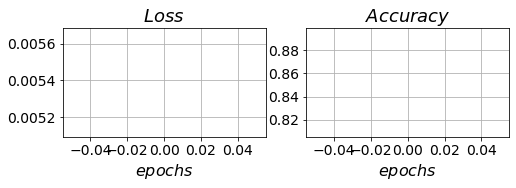

Epoch: 1 [128/6870 (2%)],	Accuracy: 12.5%,  	 Loss: 3.065248
Epoch: 1 [256/6870 (4%)],	Accuracy: 17.2%,  	 Loss: 2.932015
Epoch: 1 [384/6870 (6%)],	Accuracy: 18.8%,  	 Loss: 2.946588
Epoch: 1 [512/6870 (7%)],	Accuracy: 24.2%,  	 Loss: 2.871668
Epoch: 1 [640/6870 (9%)],	Accuracy: 23.4%,  	 Loss: 2.829170
Epoch: 1 [768/6870 (11%)],	Accuracy: 34.4%,  	 Loss: 2.583866
Epoch: 1 [896/6870 (13%)],	Accuracy: 33.6%,  	 Loss: 2.584802
Epoch: 1 [1024/6870 (15%)],	Accuracy: 41.4%,  	 Loss: 2.556270
Epoch: 1 [1152/6870 (17%)],	Accuracy: 49.2%,  	 Loss: 2.379810
Epoch: 1 [1280/6870 (19%)],	Accuracy: 44.5%,  	 Loss: 2.494615
Epoch: 1 [1408/6870 (20%)],	Accuracy: 44.5%,  	 Loss: 2.335653
Epoch: 1 [1536/6870 (22%)],	Accuracy: 45.3%,  	 Loss: 2.449466
Epoch: 1 [1664/6870 (24%)],	Accuracy: 67.2%,  	 Loss: 2.163821
Epoch: 1 [1792/6870 (26%)],	Accuracy: 65.6%,  	 Loss: 2.144805
Epoch: 1 [1920/6870 (28%)],	Accuracy: 59.4%,  	 Loss: 2.139943
Epoch: 1 [2048/6870 (30%)],	Accuracy: 67.2%,  	 Loss: 2.057282
Epoc

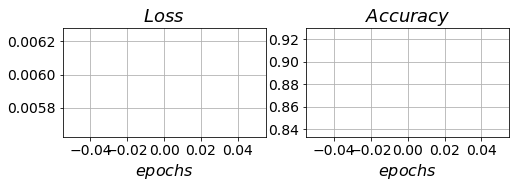

Epoch: 1 [128/7137 (2%)],	Accuracy: 11.7%,  	 Loss: 3.185579
Epoch: 1 [256/7137 (4%)],	Accuracy: 12.5%,  	 Loss: 3.000513
Epoch: 1 [384/7137 (5%)],	Accuracy: 18.0%,  	 Loss: 2.859849
Epoch: 1 [512/7137 (7%)],	Accuracy: 21.9%,  	 Loss: 2.752277
Epoch: 1 [640/7137 (9%)],	Accuracy: 24.2%,  	 Loss: 2.748213
Epoch: 1 [768/7137 (11%)],	Accuracy: 21.1%,  	 Loss: 2.795141
Epoch: 1 [896/7137 (13%)],	Accuracy: 37.5%,  	 Loss: 2.543952
Epoch: 1 [1024/7137 (14%)],	Accuracy: 29.7%,  	 Loss: 2.525436
Epoch: 1 [1152/7137 (16%)],	Accuracy: 42.2%,  	 Loss: 2.377491
Epoch: 1 [1280/7137 (18%)],	Accuracy: 57.0%,  	 Loss: 2.249463
Epoch: 1 [1408/7137 (20%)],	Accuracy: 55.5%,  	 Loss: 2.367815
Epoch: 1 [1536/7137 (22%)],	Accuracy: 61.7%,  	 Loss: 2.373726
Epoch: 1 [1664/7137 (23%)],	Accuracy: 60.2%,  	 Loss: 2.209232
Epoch: 1 [1792/7137 (25%)],	Accuracy: 55.5%,  	 Loss: 2.443723
Epoch: 1 [1920/7137 (27%)],	Accuracy: 63.3%,  	 Loss: 2.366130
Epoch: 1 [2048/7137 (29%)],	Accuracy: 68.8%,  	 Loss: 2.276096
Epoc

KeyboardInterrupt: 

In [6]:
save_model_setting(model_settings,used_model,domains,dataset,save_name)

for i in range(1,number_of_tests+1):
    try_check = i
    
    for test_idx in [3,2,1,0]:
        
        ##########################
        #### Training Setting ####
        ##########################
        if training_setting=='classic':
            train_loader, val_loader, test_loader, optimizer, model, lr_scheduler, swa_model, swa_scr = classic_setting(
                test_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model, pacs_ver,used_optimizer
            )
        elif training_setting=='IDCL':
            train_loaders, val_loaders, test_loader, optimizer, model, lr_scheduler,swa_model, swa_scr = IDCL_setting(
                test_idx, domains, batch_size, is_pretrained, train_tf, test_tf, used_model, pacs_ver, used_optimizer
            )
        else:
            raise NotImplementedError
        
        save_dir = save_route(test_idx, domains, dataset, save_name, used_model)
        

        try:
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
        except:
            print('Error : Creating directory. '+ save_dir)
        
                
        ##########################
        ####     Training     ####
        ##########################
        
        if training_setting=='classic':
            model, losses, accuracies = classic_training(
                device, epochs, model,optimizer, criterion, train_loader, val_loader, 
                lr_scheduler,is_self_reg=is_self_reg, 
                swa_model=swa_model, swa_scr=swa_scr
            )
            test_accuracy,_,__ = classic_test(device, model,criterion, test_loader,used_model, save_dir, try_check)
        elif training_setting=='IDCL':
            model, losses, accuracies = IDCL_training(
                device, epochs, model,optimizer, criterion, 
                train_loaders, val_loaders,
                lr_scheduler, is_self_reg=is_self_reg,
                swa_model=swa_model, swa_scr=swa_scr
            )
            test_accuracy,_,__ = classic_test(device, model,criterion, test_loader,used_model, save_dir, try_check)
        else:
            raise NotImplementedError
            

        total_result_text_path=os.path.join(save_dir,"test_total_result.txt")
        with open(total_result_text_path,"a") as f:
            print(test_accuracy)
            f.write(str(test_accuracy)+"\n")    
            
            
        plotting(losses, accuracies, used_model, save_dir, is_pretrained, try_check)
#         save_model(model, used_model, save_dir, is_pretrained, try_check)
        
        

